In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.interpolate import interp1d

import os
import json


#plot Options
import matplotlib as mpl
font = {#'family' : 'normal','weight' : 'bold',
        'size'   : 16
        #,'serif':['Helvetica']
        }
mpl.rc('font', **font)
mpl.rcParams['figure.dpi'] = 400

###
####constants
degree = np.pi/180 # convert form rad to degree


Attempt to model that the Capillary gets obscured by its housing 
in parts and not all at once

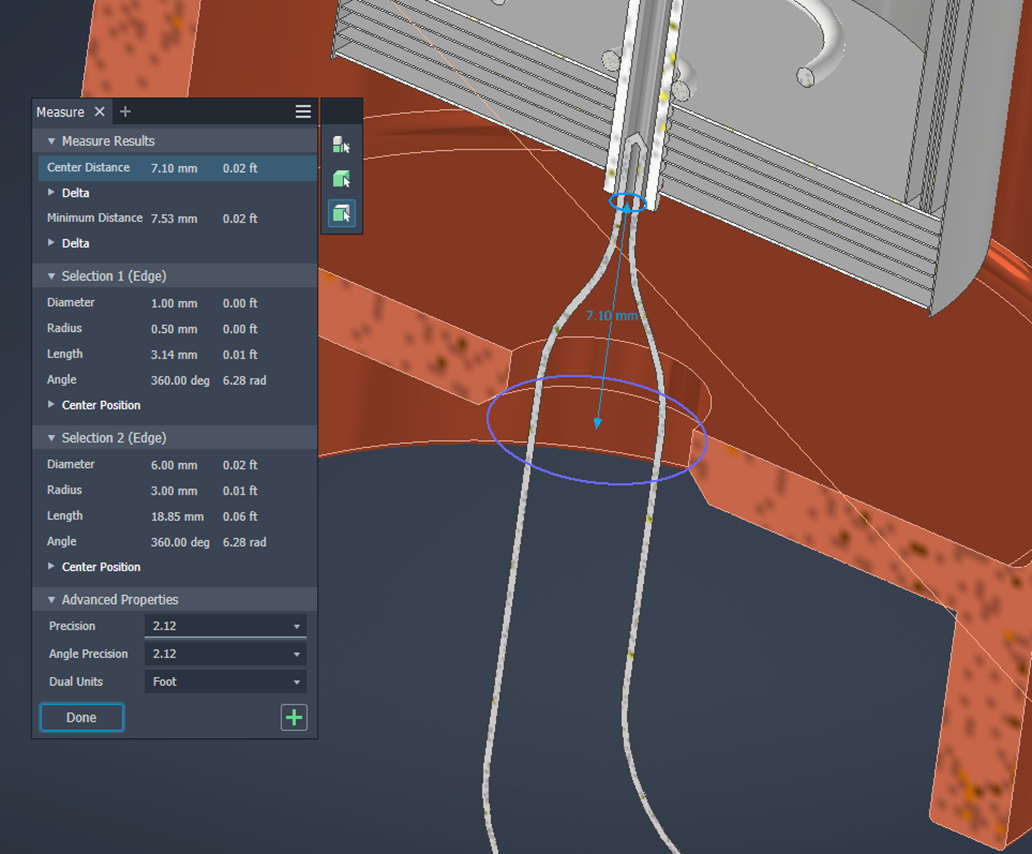

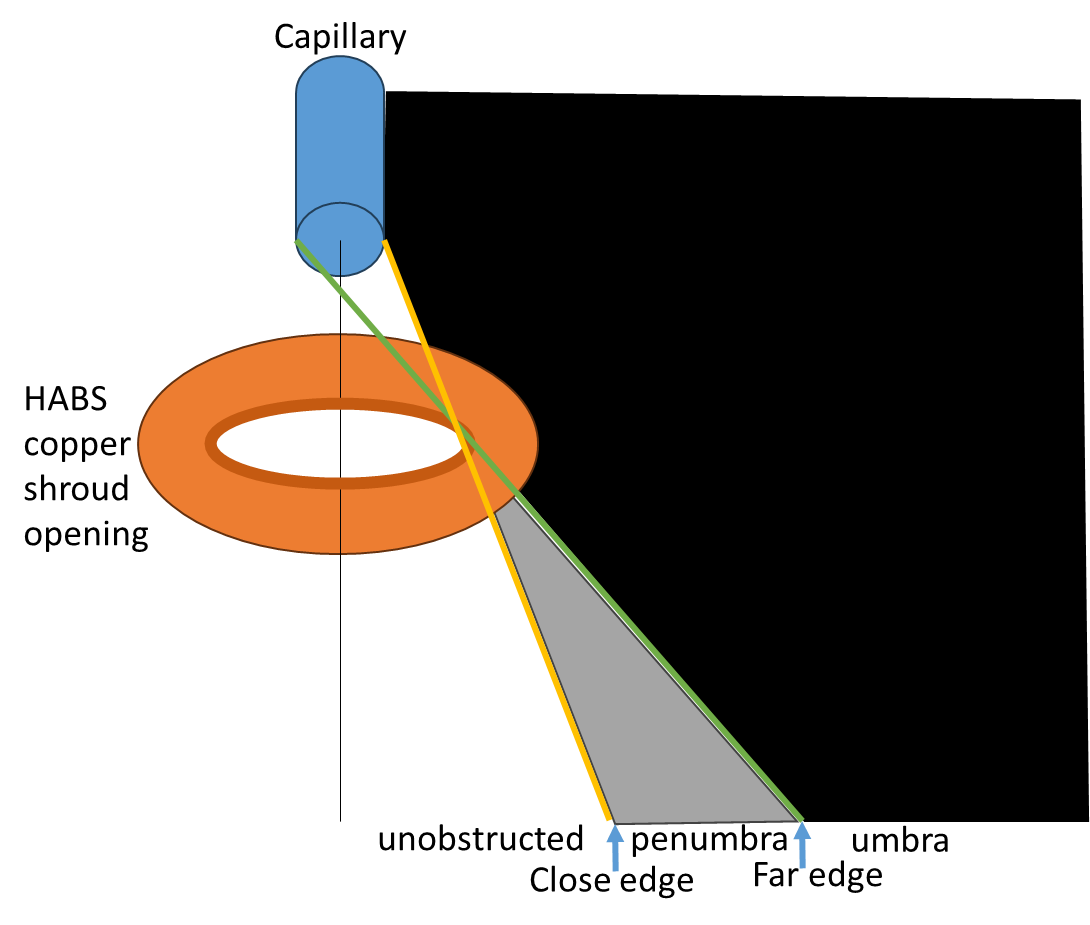

In [4]:
#2024-04-12 new version to be a real integral  over the capillary surface, and 
# to include an approximation for capillary intensity variation as seen in
# Sebastian Kochhs approximation
def visible_fraction(theta):
    # calculate fraction of the capillary that is visible under a
    # given angle
    # Presumes capillary to be centered on opening  in HABS housing
    radius_cap = 0.5 # mm
    distance_cap_housing = 7.1 # mm
    radius_housing = 3.0 # mm

    # calculate edges of penumbra
    # inner (close) edge
    theta_inner = np.arctan((radius_housing - radius_cap)
                            /distance_cap_housing)
    theta_outer = np.arctan((radius_housing + radius_cap)
                            /distance_cap_housing)

    # print("inner edge:", theta_inner, theta_inner / degree)
    # print("outer edge:", theta_outer, theta_outer / degree)#
    # # speed up by eliminating  this calculation
    # theta_inner = 0.3385556949116842 # 19.3978 deg 
    # theta_outer = 0.45799795159722173 # 26.2413 deg
    if np.abs(theta) <= theta_inner:
        fraction = 1
    elif np.abs(theta) >= theta_outer:
        fraction = 0
    else:
        # Take shortcut initially
        # HACK Linearly interpolate between inner and outer angles
        int_var = (2 *  ((theta_outer - np.abs(theta)) 
                    / (theta_outer - theta_inner))) - 1
        # Integrated circle equation
        vis_frac = lambda x: (np.sqrt(1-x**2) * x 
                                + np.arcsin(x)
                                + np.pi/2)/np.pi
        fraction = vis_frac(int_var)
    return fraction
    

In [5]:
visible_fraction(26*degree)

0.011123691454085673

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arcsin
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


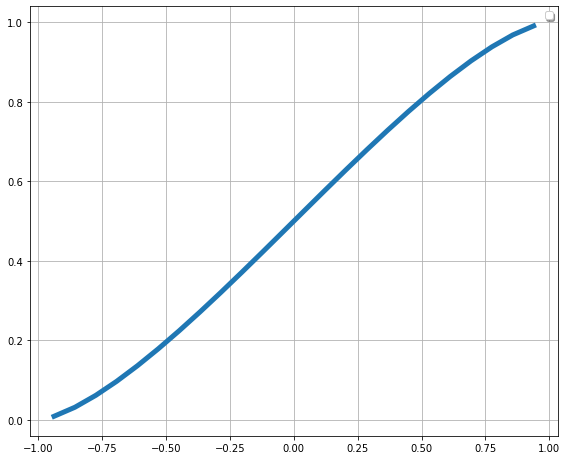

In [6]:
circ_int = lambda x: (np.sqrt(1-x**2) * x 
                        + np.arcsin(x)
                        + np.pi/2)/np.pi
xs = np.linspace(-2,2)
ys = np.real(circ_int(xs))
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()
ax1.plot(xs,ys,
        # color = "k" ,label = r"calib weights",
         lw= 5)


# ax1.set_xlabel(r"x [mm]")
# ax1.set_ylabel(r"A.U.")

plt.legend(shadow=True)
plt.tight_layout()
plt.grid(True)

In [7]:
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg

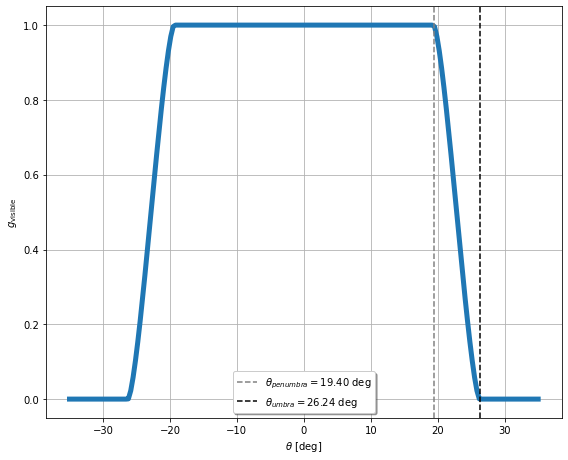

In [8]:

xs = np.linspace(-35,35, 200)
# ys = visible_fraction(xs * degree)
ys = [visible_fraction(x * degree) for x in xs]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()
ax1.plot(xs,ys,
        # color = "k" ,label = r"calib weights",
         lw= 5)


ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} deg", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} deg", 
        color = "k", alpha = 1, ls = "--")

ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$g_{\rm{visible}}$")

plt.legend(shadow=True)
plt.tight_layout()
plt.grid(True)

### Plot extracted beam shape with l_eff and visible fraction

In [9]:
degree = np.pi/180
# remember to input values in radians
def beta(theta, l_eff):

    output = np.zeros_like(theta) 
    cond = np.abs(l_eff * np.tan(theta)) < 1
    output[cond] =  np.arccos(l_eff * np.tan(theta[cond]))
    return output


def U(theta, l_eff):
    # Move conditional to beta only
    return (2*beta(theta, l_eff)-np.sin(2*beta(theta, l_eff)))/np.pi

def V(theta, l_eff):
    # Move conditional to beta only
    return np.sin(beta(theta, l_eff))**3

def jd(theta, l_eff):
    return np.cos(theta) * U(theta, l_eff)

def jw(theta, l_eff):
    result = (
    (4/(3*np.pi))*(1-1/(2*l_eff + 1)) * (1/l_eff) 
    * (np.cos(theta)**2 / np.sin(theta)) 
    * (1-V(theta, l_eff))
    + (1/(2*l_eff + 1))*np.cos(theta) * (1-U(theta, l_eff))
    )
    return result

def j(theta, l_eff):
    return jd(theta, l_eff) + jw(theta, l_eff)

In [10]:
def new_H_profile(theta, l_eff):
    return j(theta, l_eff) * visible_fraction(theta)

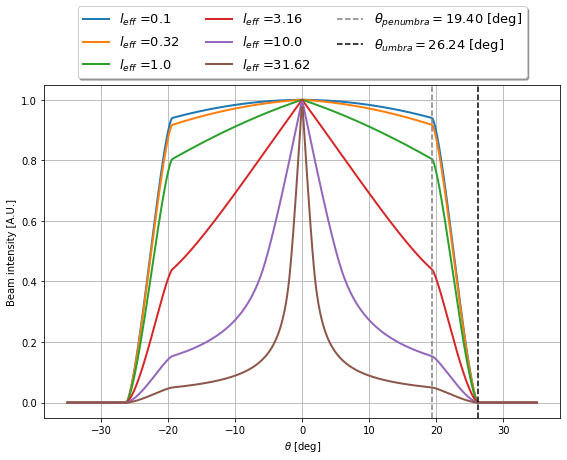

In [11]:
l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [new_H_profile(np.abs(x) * degree, l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{eff}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Beam intensity [A.U./sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 13
            )
plt.tight_layout()
plt.grid(True)

Calculate MAss spec beam opening size

In [22]:
np.tan(2/200)/degree

0.572976894487969

Plot the same but integrated over solid angle

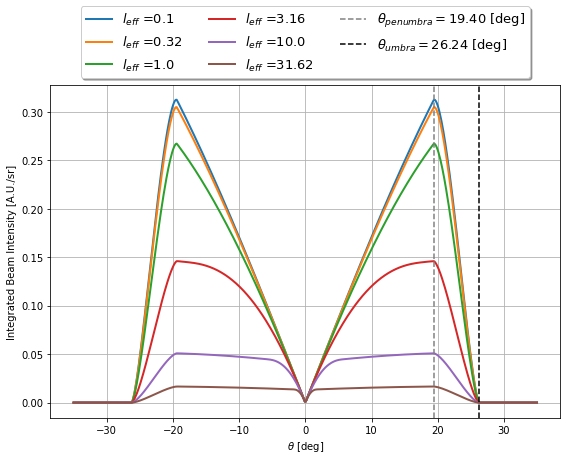

In [12]:
l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [np.sin(np.abs(x) * degree)*new_H_profile(np.abs(x) * degree, 
                                                   l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{eff}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Integrated Beam Intensity [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 13
            )
plt.tight_layout()
plt.grid(True)

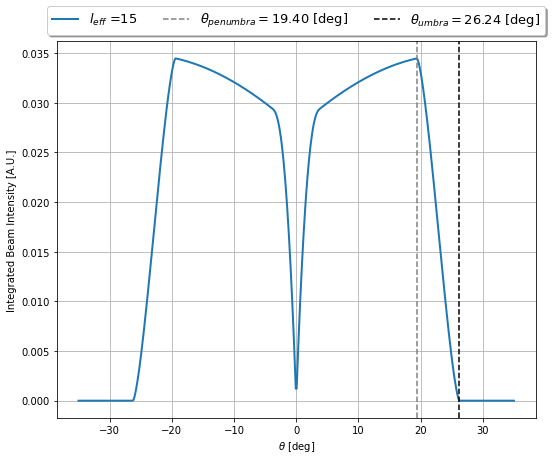

In [19]:
l_effs = [15]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [np.sin(np.abs(x) * degree)*new_H_profile(np.abs(x) * degree, 
                                                   l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{eff}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Integrated Beam Intensity [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 13
            )
plt.tight_layout()
plt.grid(True)

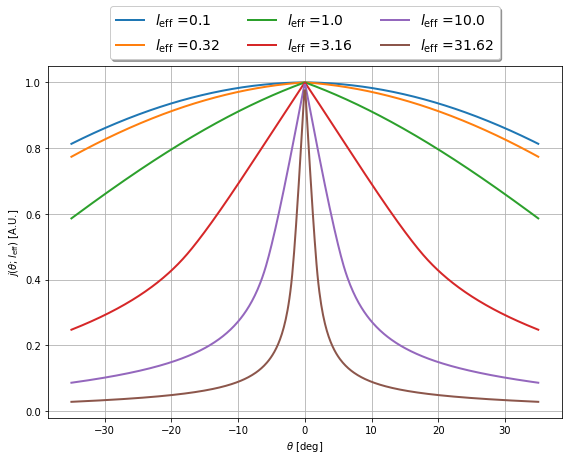

In [13]:
l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [j(np.abs(x) * degree, l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


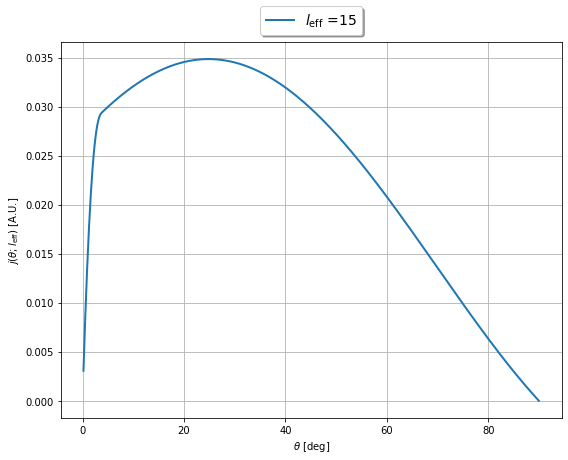

In [18]:
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [15]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,90, 500)
    # ys = visible_fraction(xs * degree)
    ys = [np.sin(np.abs(x) * degree)*j(np.abs(x) * degree, l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


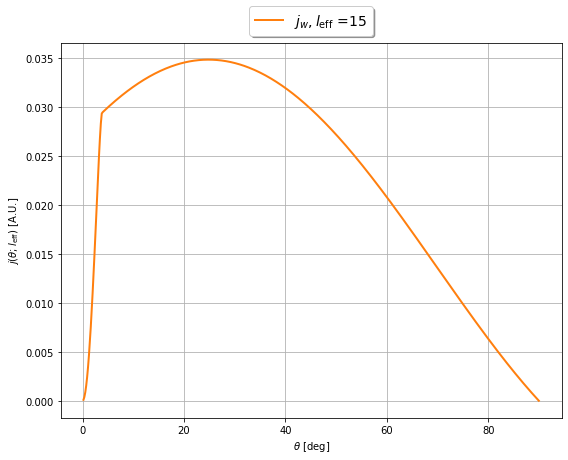

In [25]:
''' JUST jw'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [15]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,90, 500)
    # ys = visible_fraction(xs * degree)
    ys = [np.sin(np.abs(x) * degree)*jw(np.abs(x) * degree, l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


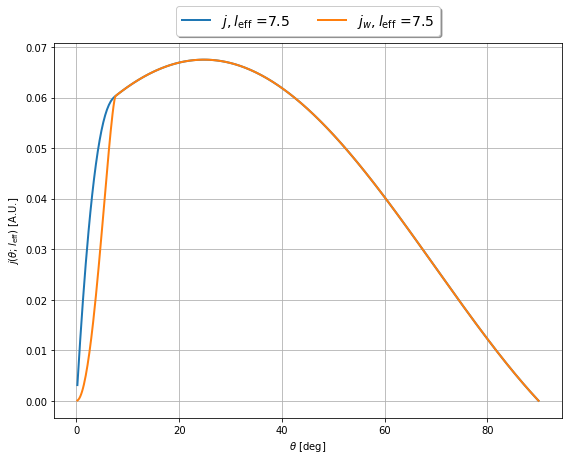

In [31]:
''' j and jw'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,90, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = [np.sin(np.abs(x) * degree)*j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]
    ys = [np.sin(np.abs(x) * degree)*jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

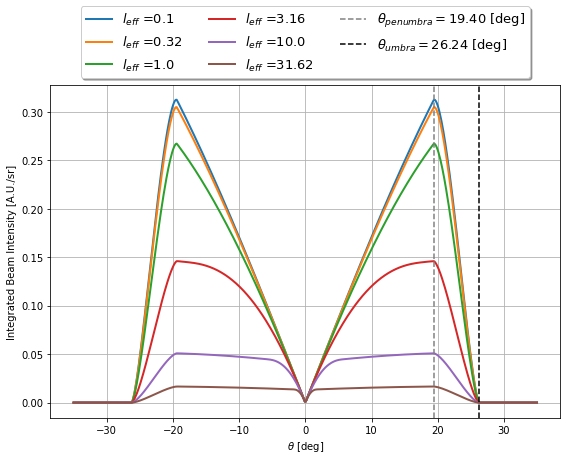

In [ ]:
l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [np.sin(np.abs(x) * degree)*new_H_profile(np.abs(x) * degree, 
                                                   l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{eff}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Integrated Beam Intensity [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 13
            )
plt.tight_layout()
plt.grid(True)

### Plot H profile with error band

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


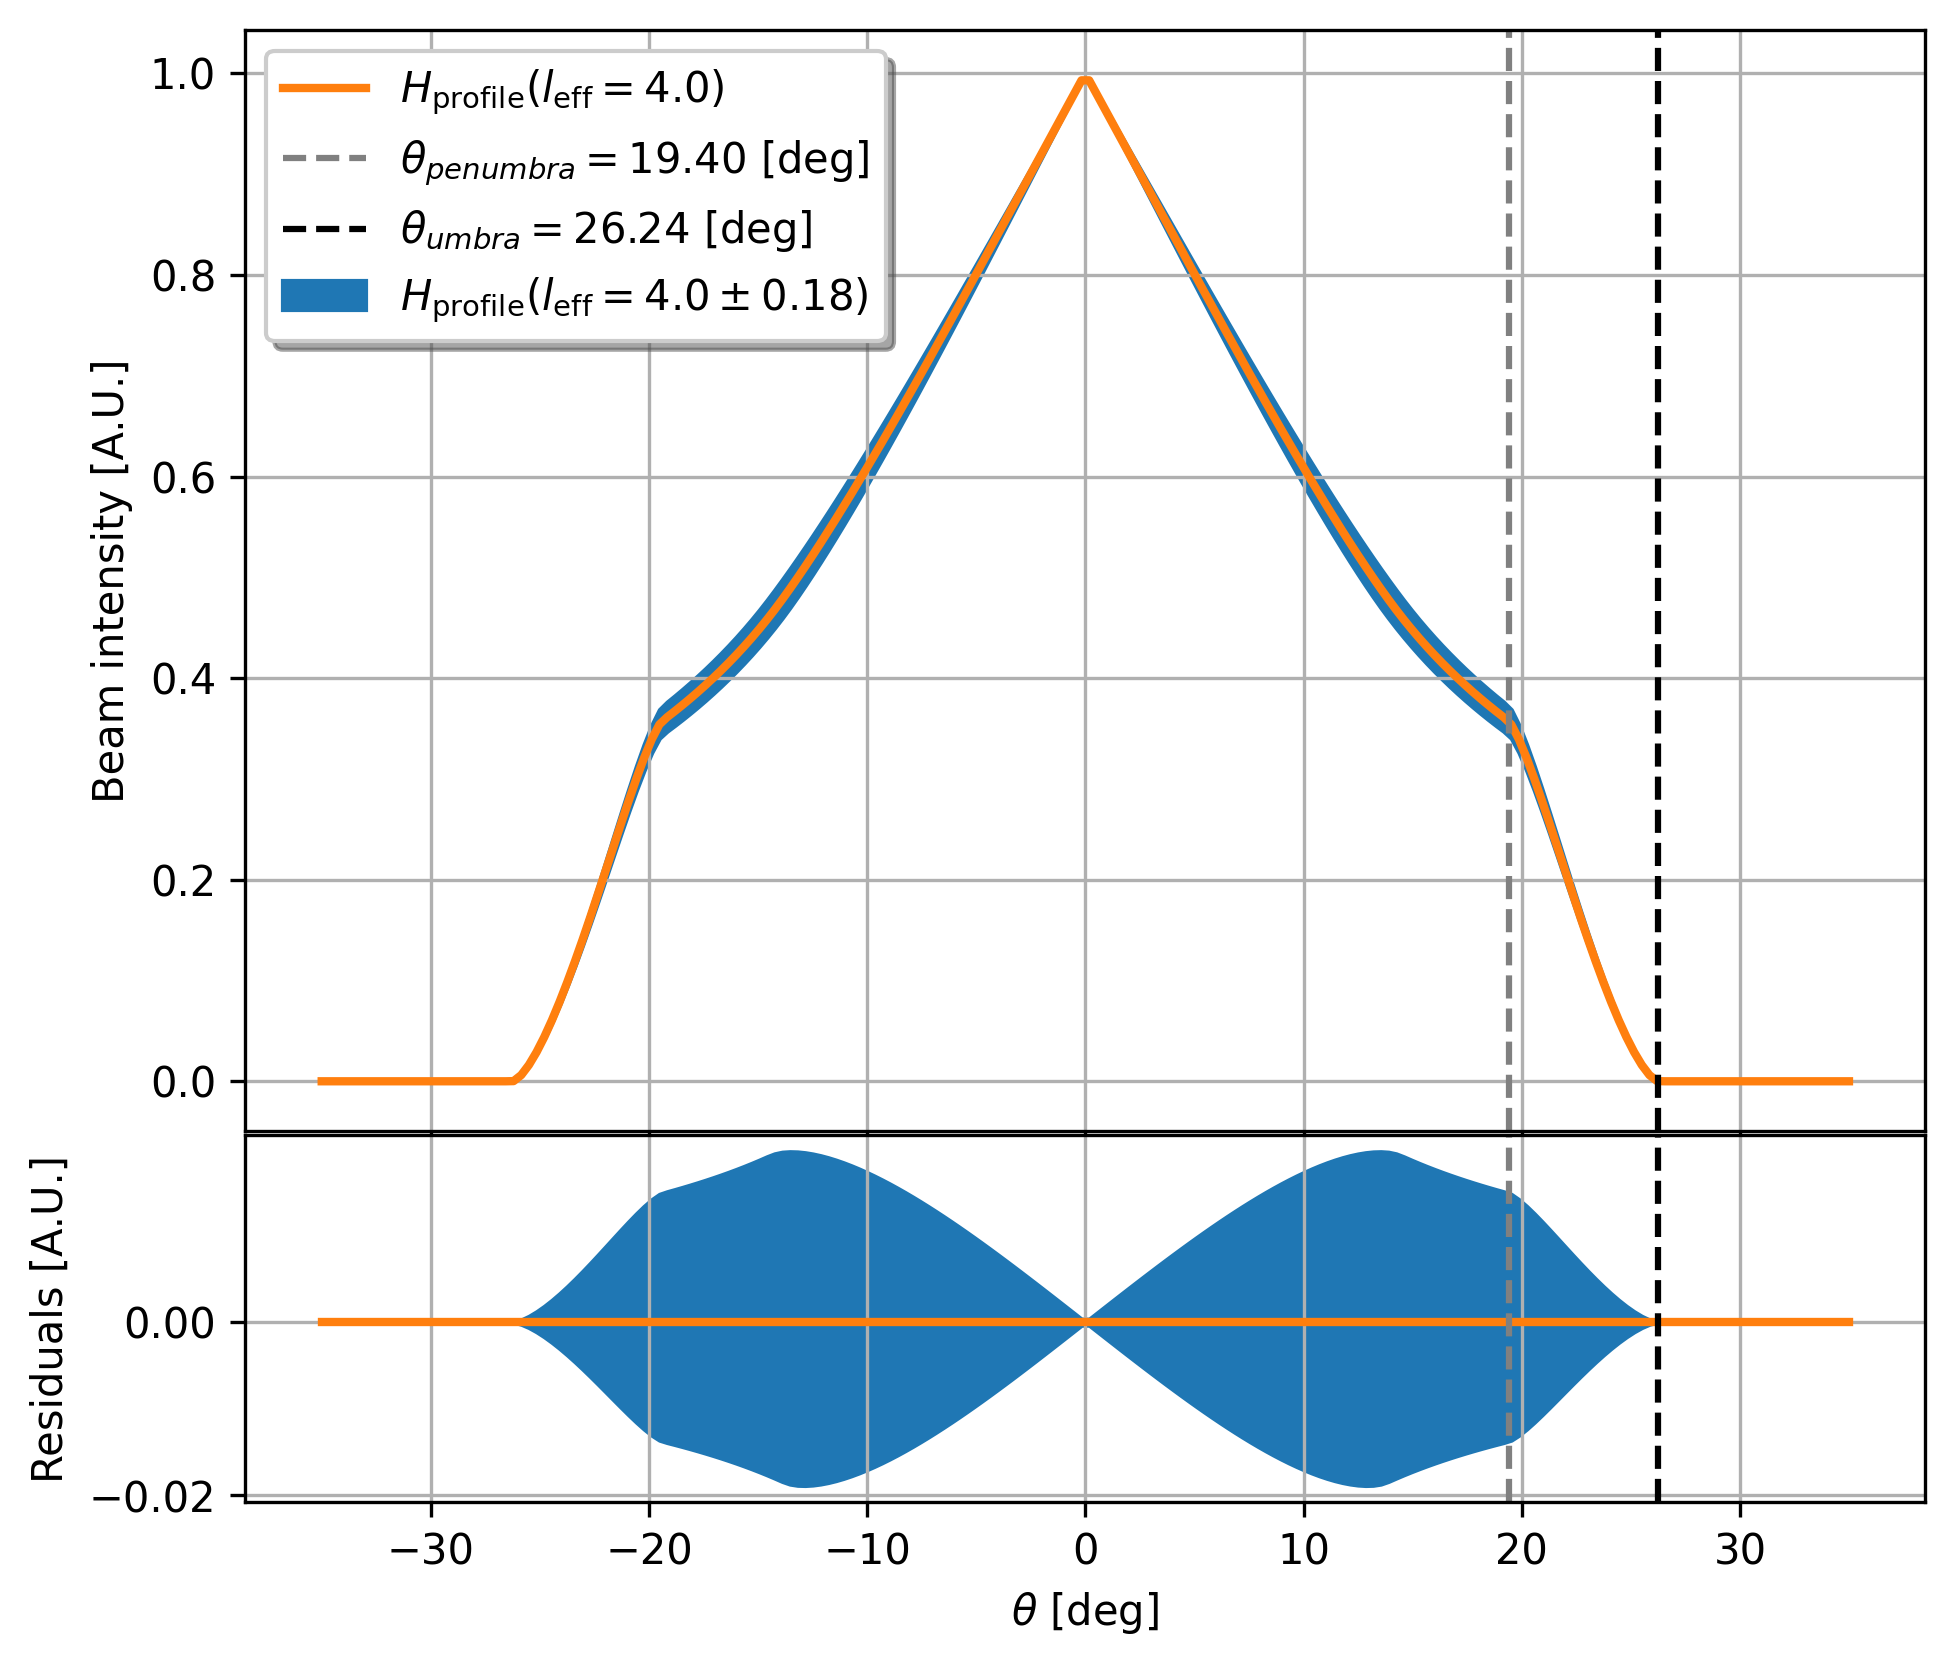

In [14]:
xs = np.linspace(-35,35, 200)
# ys = visible_fraction(xs * degree)
ys = np.array([new_H_profile(np.abs(x) * degree, l_eff = 4.0) for x in xs])
ys_high = np.array([new_H_profile(np.abs(x) * degree, l_eff = 4.0 +0.18) 
                    for x in xs])
ys_low = np.array(
    [new_H_profile(np.abs(x) * degree, l_eff = 4.0 -0.18) for x in xs]
                 ) 


fig = plt.figure(0, figsize=(8,6.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
        )
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


ax1.fill_between(xs,ys_high,ys_low,
        color = "C0" ,label = r"$H_{\rm{profile}}(l_{\rm{eff}} = 4.0 \pm 0.18)$",
         #lw= 4
         )
ax1.plot(xs,ys,
        color = "C1" ,
        label = r"$H_{\rm{profile}}(l_{\rm{eff}} = 4.0)$",
         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Beam intensity [A.U.]")

ax1.grid(True)
ax1.legend(shadow=True, fontsize="10")


ax2.fill_between(xs,ys_high - ys,ys_low-ys,
        color = "C0" ,label = r"$H_{\rm{profile}}(l_{\rm{eff}} = 4.0 \pm 0.18)$",
         #lw= 4
         )

ax2.plot(xs,ys-ys,
        color = "C1" ,
        label = r"$H_{\rm{profile}}(l_{\rm{eff}} = 4.0)$",
         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax2.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax2.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax2.set_xlabel(r"$\theta$ [deg]")
ax2.set_ylabel(r"Residuals [A.U.]")

ax2.grid(True)




#make custom pruning of uppper tick (do not plot ticks in upper 10%)
#so that ax2 tick does nto interfere with  ax1 tick
ax2.locator_params(axis="y", min_n_ticks = 3
                    )
y_loc = ax2.yaxis.get_majorticklocs()
x_loc = ax1.xaxis.get_majorticklocs()
#print("y_loc: ", y_loc)
#print("y_loc[1:-2]: ", y_loc[1:-2])
#print("ylim: ", ax2.get_ylim())
y2_min, y2_max = ax2.get_ylim()
y_loc = [y for y in y_loc if y2_min < y < y2_max - (y2_max -
                                                     y2_min)*0.1]
#print("y_loc: ", y_loc)
ax2.set_yticks(y_loc)
# set  x lims:
x1_min, x1_max = ax1.get_xlim()
ax2.set_xticks(x_loc)
ax2.set_xlim(ax1.get_xlim())
# Delete xticks on 1st axis
ax1.set_xticklabels([])
fig.tight_layout()
fig.subplots_adjust(left=0.2)

#### Change to values returned with Cv corretion

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


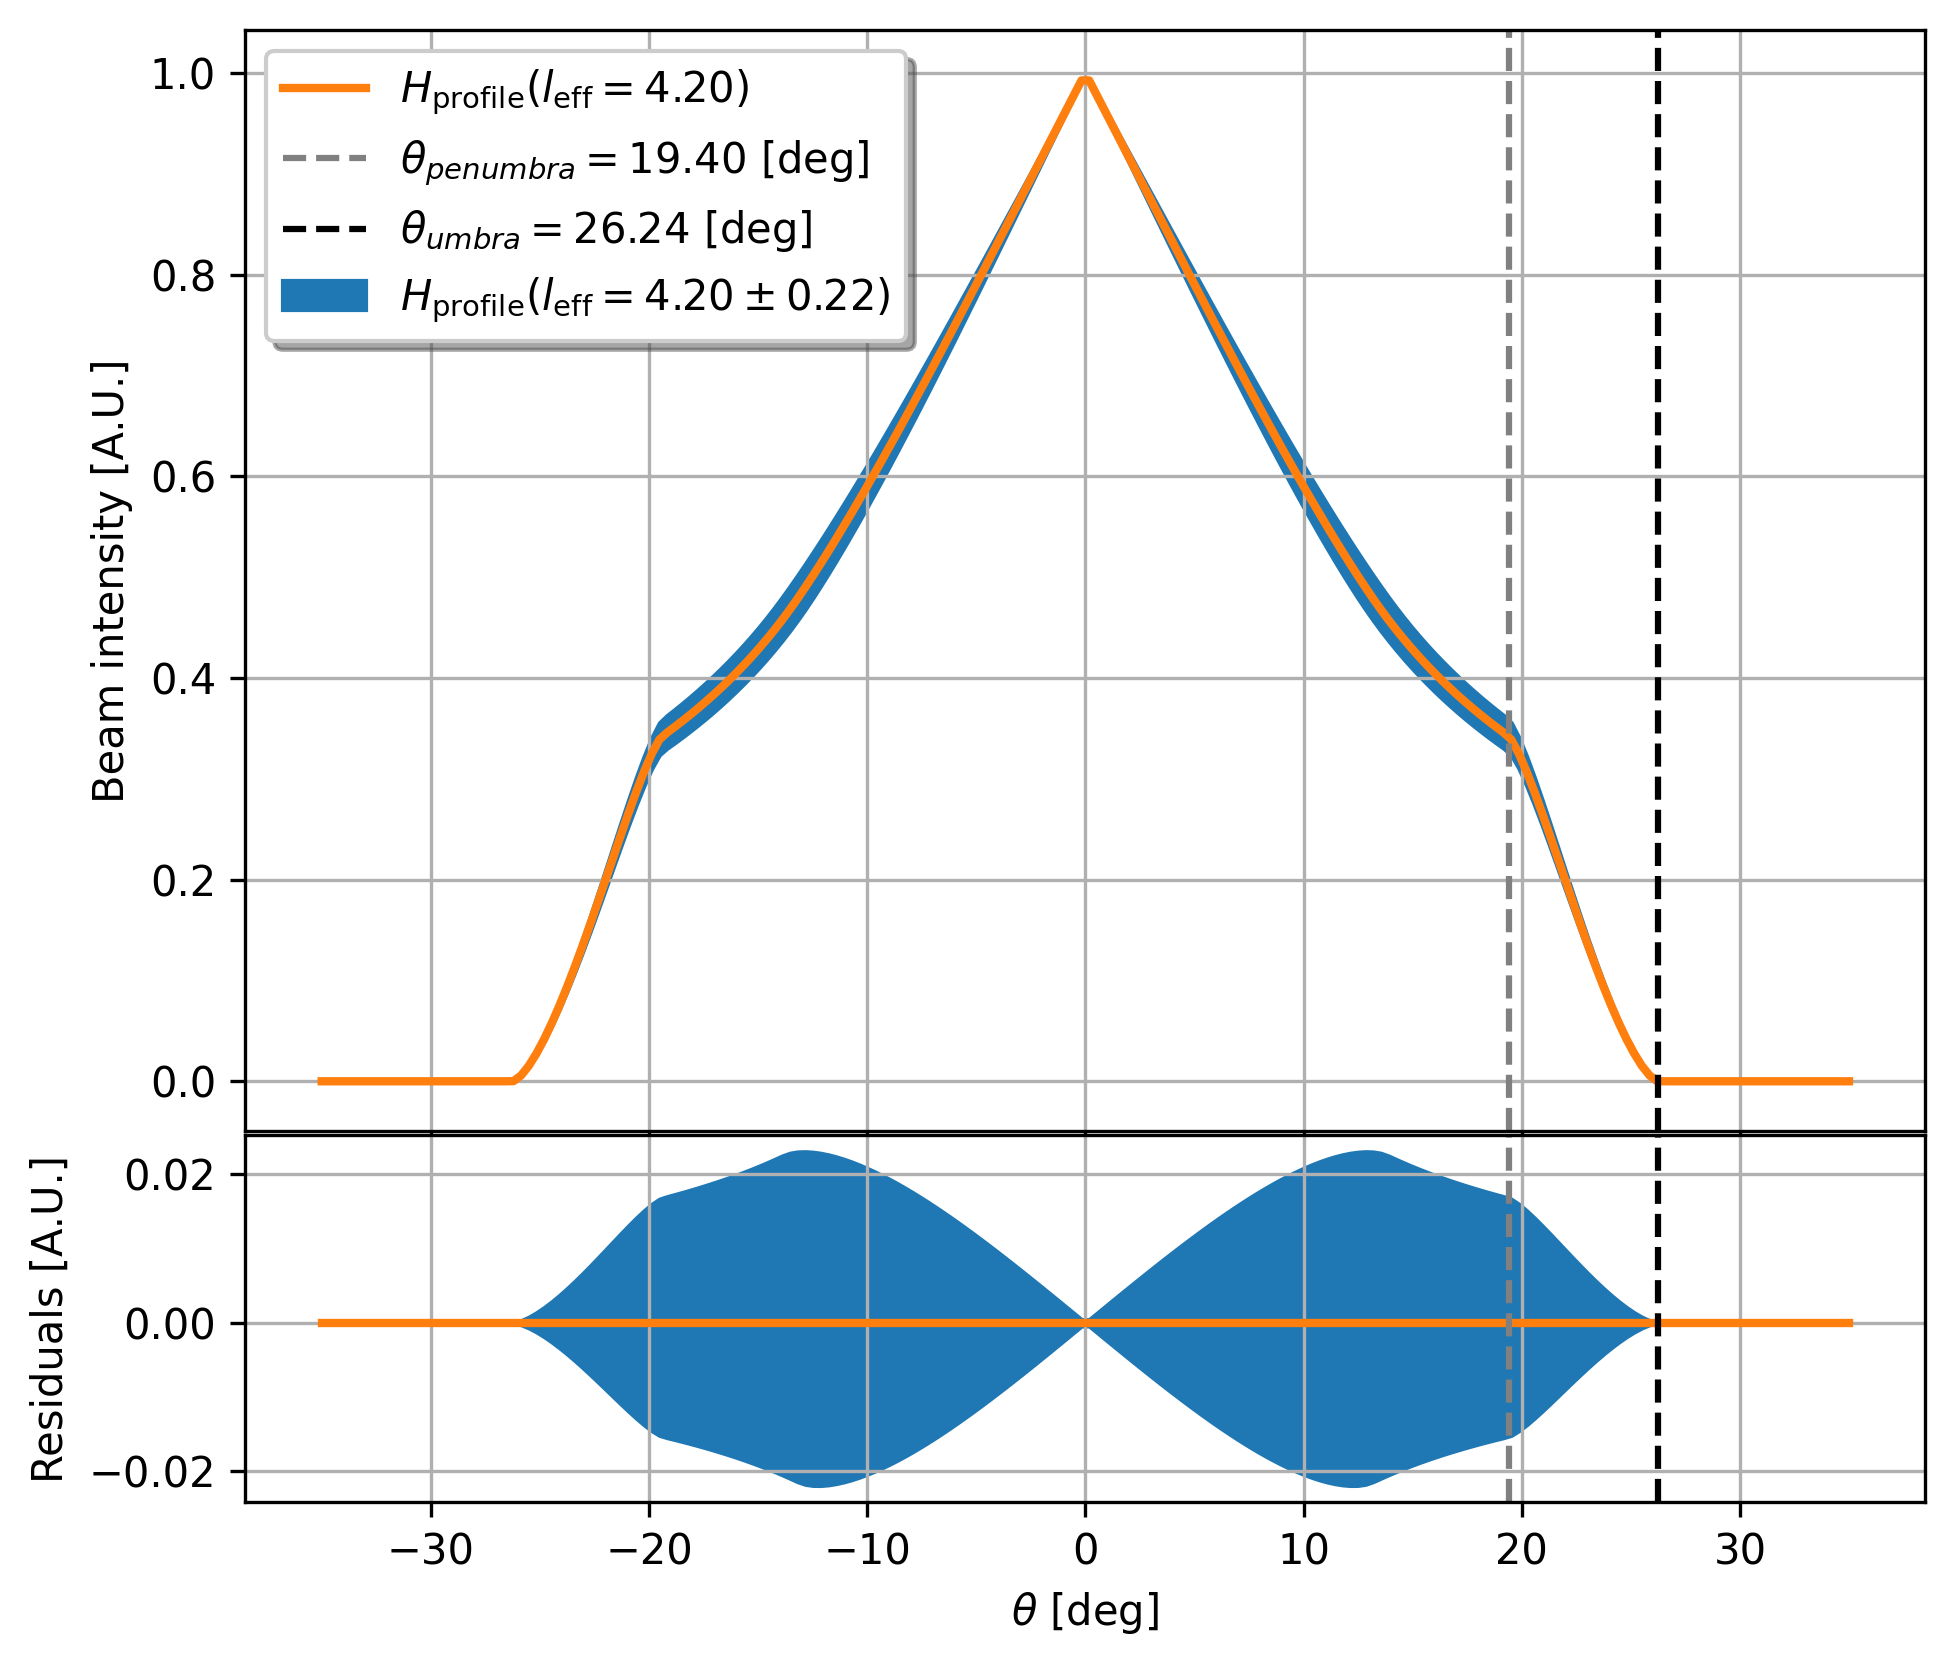

In [15]:
xs = np.linspace(-35,35, 200)
# ys = visible_fraction(xs * degree)
ys = np.array([new_H_profile(np.abs(x) * degree, l_eff = 4.20) for x in xs])
ys_high = np.array([new_H_profile(np.abs(x) * degree, l_eff = 4.20 +0.22) 
                    for x in xs])
ys_low = np.array(
    [new_H_profile(np.abs(x) * degree, l_eff = 4.20 -0.22) for x in xs]
                 ) 


fig = plt.figure(0, figsize=(8,6.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
        )
    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


ax1.fill_between(xs,ys_high,ys_low,
        color = "C0" ,label = r"$H_{\rm{profile}}(l_{\rm{eff}} = 4.20 \pm 0.22)$",
         #lw= 4
         )
ax1.plot(xs,ys,
        color = "C1" ,
        label = r"$H_{\rm{profile}}(l_{\rm{eff}} = 4.20)$",
         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Beam intensity [A.U.]")

ax1.grid(True)
ax1.legend(shadow=True, fontsize="10")


ax2.fill_between(xs,ys_high - ys,ys_low-ys,
        color = "C0" ,label = r"$H_{\rm{profile}}(l_{\rm{eff}} = 4.20 \pm 0.22)$",
         #lw= 4
         )

ax2.plot(xs,ys-ys,
        color = "C1" ,
        label = r"$H_{\rm{profile}}(l_{\rm{eff}} = 4.20)$",
         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax2.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax2.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax2.set_xlabel(r"$\theta$ [deg]")
ax2.set_ylabel(r"Residuals [A.U.]")

ax2.grid(True)




#make custom pruning of uppper tick (do not plot ticks in upper 10%)
#so that ax2 tick does nto interfere with  ax1 tick
ax2.locator_params(axis="y", min_n_ticks = 3
                    )
y_loc = ax2.yaxis.get_majorticklocs()
x_loc = ax1.xaxis.get_majorticklocs()
#print("y_loc: ", y_loc)
#print("y_loc[1:-2]: ", y_loc[1:-2])
#print("ylim: ", ax2.get_ylim())
y2_min, y2_max = ax2.get_ylim()
y_loc = [y for y in y_loc if y2_min < y < y2_max - (y2_max -
                                                     y2_min)*0.1]
#print("y_loc: ", y_loc)
ax2.set_yticks(y_loc)
# set  x lims:
x1_min, x1_max = ax1.get_xlim()
ax2.set_xticks(x_loc)
ax2.set_xlim(ax1.get_xlim())
# Delete xticks on 1st axis
ax1.set_xticklabels([])
fig.tight_layout()
fig.subplots_adjust(left=0.2)